📢 해당 게시물은 파이토치 공식 튜토리얼 중 [파이토치 기본 익히기(QuickStart)](https://tutorials.pytorch.kr/beginner/basics/quickstart_tutorial.html)와 PyTorch로 시작하는 딥 러닝 입문 > [커스텀 데이터셋](https://wikidocs.net/57165)를 재구성하여 작성되었습니다.

In [1]:
import torch
from torch import nn

# 데이터 작업을 위한 기본 요소 두 가지
from torch.utils.data import DataLoader # dataset 을 순회 가능한 interable로 감쌉니다.
from torchvision import datasets # 샘플과 정답(Lable)을 저장합니다.

from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

파이토치 가이드([link](https://tutorials.pytorch.kr/beginner/basics/quickstart_tutorial.html))를 보면서 각 코드가 의미하는 바를 주석을 달아 해석하세요.

# 1. 데이터 불러오기

`torchvision.datasets`에는 다양한 비전 데이터들을 제공하는데, 이 튜토리얼에서는 `FashionMNIST`를 사용하였다고 한다.

In [2]:
# 공개 데이터셋에서 학습 데이터 내려받기.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터 내려받기.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



`DataLoader`: 데이터 로더를 생성합니다. 이는 데이터셋을 순회 가능한 객체(iterable)로 감싸고, 자동화된 배치(batch), 샘플링(sampling), 섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원합니다.

In [3]:
batch_size = 64
# 데이터로더(dataloader) 객체의 각 요소는 64개의 특징(feature)과 정답(label)을 묶음(batch)으로 반환합니다.

# 데이터 로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


## 1-1. 시각화하기

Dataset 에 리스트(list)처럼 직접 접근(index)할 수 있습니다: training_data[index]. matplotlib 을 사용하여 학습 데이터의 일부를 시각화해보겠습니다.

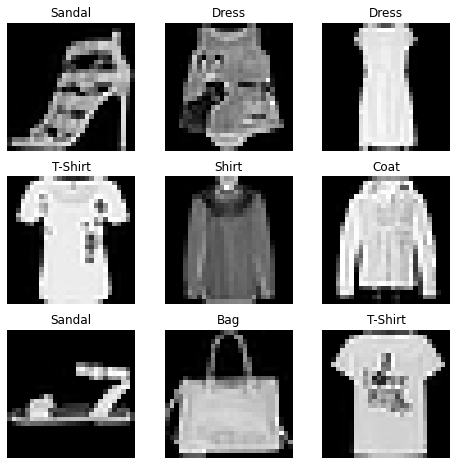

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 1-2. 사용자 정의 데이터셋 생성

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: __init__, __len__, and __getitem__. 아래 구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장됩니다.

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import Dataset

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다.
        #여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 (다음 장에서 자세히 살펴볼) 두가지 변형(transform)을 초기화합니다.
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label']) 
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # __len__ 함수는 데이터셋의 샘플 개수를 반환합니다.
        return len(self.img_labels)

    def __getitem__(self, idx):
        # __getitem__ 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다.
        # 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고,
        # self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고,
        # (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환합니다.

        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# 2. 모델 생성

PyTorch에서 신경망 모델은 nn.Module 을 상속받는 클래스(class)를 생성하여 정의합니다. __init__ 함수에서 신경망의 계층(layer)들을 정의하고 forward 함수에서 신경망에 데이터를 어떻게 전달할지 지정합니다. 가능한 경우 GPU로 신경망을 이동시켜 연산을 가속(accelerate)합니다.

In [8]:
# 학습에 사용할 CPU나 GPU장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 2-1. 모델 layer 살펴보기

- input data
    - FashionMNIST 모델의 계층들을 살펴보겠습니다. 이를 설명하기 위해, 28x28 크기의 이미지 3개로 구성된 미니배치를 가져와, 신경망을 통과할 때 어떤 일이 발생하는지 알아보겠습니다.

In [10]:
input_image = torch.rand(3,28,28) 
print(input_image.size())

torch.Size([3, 28, 28])


- nn.Flatten
    - nn.Flatten 계층을 초기화하여 각 28x28의 2D 이미지를 784 픽셀 값을 갖는 연속된 배열로 변환합니다. (dim=0의 미니배치 차원은 유지됩니다.)

In [11]:
flatten = nn.Flatten() 
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


- nn.Linear
    - 선형 계층 은 저장된 가중치(weight)와 편향(bias)을 사용하여 입력에 선형 변환(linear transformation)을 적용하는 모듈입니다.

In [12]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


- nn.ReLU
    - 비선형 활성화(activation)는 모델의 입력과 출력 사이에 복잡한 관계(mapping)를 만듭니다. 비선형 활성화는 선형 변환 후에 적용되어 비선형성(nonlinearity) 을 도입하고, 신경망이 다양한 현상을 학습할 수 있도록 돕습니다.

이 모델에서는 nn.ReLU 를 선형 계층들 사이에 사용하지만, 모델을 만들 때는 비선형성을 가진 다른 활성화를 도입할 수도 있습니다.



In [13]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.1489, -0.4603,  0.5220, -0.4416,  0.1922, -0.2349, -0.1716, -0.0579,
          0.0969,  0.2876, -0.1264, -0.2572, -0.3706,  0.4232,  0.1207,  0.7271,
          0.5800, -0.0241, -0.6143, -0.1659],
        [ 0.0615, -0.3337,  0.4400, -0.3784,  0.4889, -0.0512, -0.0582, -0.1728,
          0.3438,  0.0842, -0.2684, -0.1285, -0.1824,  0.8235,  0.2847,  0.4747,
          0.5529,  0.1077, -0.4368, -0.0377],
        [ 0.0414, -0.7057,  0.8679, -0.3764, -0.0837, -0.2643, -0.1248, -0.1575,
          0.5605,  0.4321, -0.3452, -0.1725, -0.2998,  0.6832,  0.4072,  0.4971,
          0.6361, -0.1151, -0.5354, -0.3532]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.1489, 0.0000, 0.5220, 0.0000, 0.1922, 0.0000, 0.0000, 0.0000, 0.0969,
         0.2876, 0.0000, 0.0000, 0.0000, 0.4232, 0.1207, 0.7271, 0.5800, 0.0000,
         0.0000, 0.0000],
        [0.0615, 0.0000, 0.4400, 0.0000, 0.4889, 0.0000, 0.0000, 0.0000, 0.3438,
         0.0842, 0.0000, 0.0000, 0.0000, 0.8235, 0.28

- nn.Sequential
    - nn.Sequential 은 순서를 갖는 모듈의 컨테이너입니다. 데이터는 정의된 것과 같은 순서로 모든 모듈들을 통해 전달됩니다. 순차 컨테이너(sequential container)를 사용하여 아래의 seq_modules 와 같은 신경망을 빠르게 만들 수 있습니다.

In [14]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

- nn.Softmax
    - 신경망의 마지막 선형 계층은 nn.Softmax 모듈에 전달될 ([-infty, infty] 범위의 원시 값(raw value)인) logits 를 반환합니다. logits는 모델의 각 분류(class)에 대한 예측 확률을 나타내도록 [0, 1] 범위로 비례하여 조정(scale)됩니다. dim 매개변수는 값의 합이 1이 되는 차원을 나타냅니다.

In [15]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [16]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0039, -0.0087,  0.0078,  ...,  0.0273,  0.0356,  0.0114],
        [ 0.0204,  0.0090, -0.0224,  ..., -0.0122, -0.0263,  0.0232]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0299, 0.0056], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0214,  0.0009, -0.0216,  ...,  0.0009,  0.0227, -0.0215],
        [-0.0117,  0.0083, -0.0263,  ...,  0.0058,  0.0291, -0.0274]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

# 3. 최적화

모델을 학습하려면 손실 함수(loss function) 와 옵티마이저(optimizer) 가 필요합니다.

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

각 학습 단계(training loop)에서 모델은 (배치(batch)로 제공되는) 학습 데이터셋에 대한 예측을 수행하고, 예측 오류를 역전파하여 모델의 매개변수를 조정합니다.

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

모델이 학습하고 있는지를 확인하기 위해 테스트 데이터셋으로 모델의 성능을 확인합니다.

In [19]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

학습 단계는 여러번의 반복 단계 (에폭(epochs)) 를 거쳐서 수행됩니다. 각 에폭에서는 모델은 더 나은 예측을 하기 위해 매개변수를 학습합니다. 각 에폭마다 모델의 정확도(accuracy)와 손실(loss)을 출력합니다; 에폭마다 정확도가 증가하고 손실이 감소하는 것을 보려고 합니다.

In [20]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309193  [    0/60000]
loss: 2.297372  [ 6400/60000]
loss: 2.279691  [12800/60000]
loss: 2.270878  [19200/60000]
loss: 2.250486  [25600/60000]
loss: 2.230650  [32000/60000]
loss: 2.231812  [38400/60000]
loss: 2.193572  [44800/60000]
loss: 2.199602  [51200/60000]
loss: 2.171853  [57600/60000]
Test Error: 
 Accuracy: 51.4%, Avg loss: 2.160720 

Epoch 2
-------------------------------
loss: 2.171679  [    0/60000]
loss: 2.164139  [ 6400/60000]
loss: 2.108187  [12800/60000]
loss: 2.119909  [19200/60000]
loss: 2.065613  [25600/60000]
loss: 2.021445  [32000/60000]
loss: 2.033939  [38400/60000]
loss: 1.951730  [44800/60000]
loss: 1.966911  [51200/60000]
loss: 1.895773  [57600/60000]
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.887899 

Epoch 3
-------------------------------
loss: 1.926372  [    0/60000]
loss: 1.900928  [ 6400/60000]
loss: 1.779079  [12800/60000]
loss: 1.809053  [19200/60000]
loss: 1.709912  [25600/60000]
loss: 1.668795  [32000/600

# 4. 모델 저장 및 불러오기

모델을 저장하는 일반적인 방법은 (모델의 매개변수들을 포함하여) 내부 상태 사전(internal state dictionary)을 직렬화(serialize)하는 것입니다.

In [22]:
# 모델 저장하기
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


모델을 불러오는 과정에는 모델 구조를 다시 만들고 상태 사전을 모델에 불러오는 과정이 포함됩니다.

In [24]:
# 모델 불러오기
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

이제 이 모델을 사용해서 예측을 할 수 있습니다.

In [25]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# 5. 커스텀 데이터셋(Custom Dataset)

PyTorch로 시작하는 딥 러닝 입문 > 커스텀 데이터셋([link](https://wikidocs.net/57165))을 읽고 코드들의 해석을 주석 달아주세요.

## 5-1. 커스텀 데이터셋 생성

torch.utils.data.Dataset을 상속받아 직접 커스텀 데이터셋(Custom Dataset)을 만드는 경우도 있습니다. torch.utils.data.Dataset은 파이토치에서 데이터셋을 제공하는 추상 클래스입니다. Dataset을 상속받아 다음 메소드들을 오버라이드 하여 커스텀 데이터셋을 만들어보겠습니다.

커스텀 데이터셋을 만들 때, 일단 가장 기본적인 뼈대는 아래와 같습니다. 여기서 필요한 기본적인 define은 3개입니다.

In [36]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        # 데이터셋의 전처리를 해주는 부분
        pass
    def __len__(self):
        # 데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분
        pass
    def __getitem__(self, idx):
        # 데이터셋에서 특정 1개의 샘플을 가져오는 함수
        pass

- len(dataset)을 했을 때 데이터셋의 크기를 리턴할 len
- dataset[i]을 했을 때 i번째 샘플을 가져오도록 하는 인덱싱을 위한 get_item

## 5-2. 커스텀 데이터셋(Custom Dataset)으로 선형 회귀 구현하기

In [38]:
import torch
import torch.nn.functional as F

In [39]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [42]:
# Dataset 상속
class CustomDataset(Dataset): 
  def __init__(self):
    self.x_data = [[73, 80, 75],
                   [93, 88, 93],
                   [89, 91, 90],
                   [96, 98, 100],
                   [73, 66, 70]]
    self.y_data = [[152], [185], [180], [196], [142]]

  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = torch.FloatTensor(self.x_data[idx])
    y = torch.FloatTensor(self.y_data[idx])
    return x, y

In [43]:
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [44]:
model = torch.nn.Linear(3,1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

In [45]:
nb_epochs = 20
for epoch in range(nb_epochs + 1):
  for batch_idx, samples in enumerate(dataloader):
    # print(batch_idx)
    # print(samples)
    x_train, y_train = samples
    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.mse_loss(prediction, y_train)

    # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.item()
        ))

Epoch    0/20 Batch 1/3 Cost: 15728.666016
Epoch    0/20 Batch 2/3 Cost: 6535.129883
Epoch    0/20 Batch 3/3 Cost: 2422.144287
Epoch    1/20 Batch 1/3 Cost: 514.104187
Epoch    1/20 Batch 2/3 Cost: 100.564125
Epoch    1/20 Batch 3/3 Cost: 43.256474
Epoch    2/20 Batch 1/3 Cost: 7.035266
Epoch    2/20 Batch 2/3 Cost: 30.292673
Epoch    2/20 Batch 3/3 Cost: 1.167294
Epoch    3/20 Batch 1/3 Cost: 5.735724
Epoch    3/20 Batch 2/3 Cost: 7.603871
Epoch    3/20 Batch 3/3 Cost: 3.587168
Epoch    4/20 Batch 1/3 Cost: 4.880916
Epoch    4/20 Batch 2/3 Cost: 7.170504
Epoch    4/20 Batch 3/3 Cost: 4.059546
Epoch    5/20 Batch 1/3 Cost: 8.915869
Epoch    5/20 Batch 2/3 Cost: 3.165939
Epoch    5/20 Batch 3/3 Cost: 2.712268
Epoch    6/20 Batch 1/3 Cost: 8.309174
Epoch    6/20 Batch 2/3 Cost: 3.533508
Epoch    6/20 Batch 3/3 Cost: 1.301687
Epoch    7/20 Batch 1/3 Cost: 7.927118
Epoch    7/20 Batch 2/3 Cost: 2.234487
Epoch    7/20 Batch 3/3 Cost: 7.901661
Epoch    8/20 Batch 1/3 Cost: 3.702903
Epoch    

In [46]:
# 임의의 입력 [73, 80, 75]를 선언
new_var =  torch.FloatTensor([[73, 80, 75]]) 
# 입력한 값 [73, 80, 75]에 대해서 예측값 y를 리턴받아서 pred_y에 저장
pred_y = model(new_var) 
print("훈련 후 입력이 73, 80, 75일 때의 예측값 :", pred_y) 

훈련 후 입력이 73, 80, 75일 때의 예측값 : tensor([[152.7735]], grad_fn=<AddmmBackward0>)
